# Timeseries Multi-Step Multi-Output
---

Data treatment for model 1
Features:
- local lateral position Local_X, to account for different behaviors depending on the driving lane,
- local longitudinal position Local_Y, to account for different behaviors when approaching the merging lane,
- lateral and longitudinal velocities vx and vy,
- type (motorcycle, car or truck)

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request
plt.rcParams['figure.figsize'] = (8, 6)
from math import sqrt
import os
# For data processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For prediction model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool1D, Conv1D

## Load dataset

In [3]:
#%% import data without saving it in local directory
def url2pd(link):
    url = urllib.request.urlopen(link)
    with ZipFile(BytesIO(url.read())) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading data')
    return pd.read_csv(data)

In [4]:
filenames = os.listdir('.\Data')

FileNotFoundError: [Errno 2] No such file or directory: '.\\Data'

In [ ]:
filenames = ['0750_0805_us101_smoothed_11_.zip',
             '0805_0820_us101_smoothed_11_.zip',
             '0820_0835_us101_smoothed_11_.zip',
             'trajectories-0400-0415.zip',
             'trajectories-0500-0515.zip',
             'trajectories-0515-0530.zip']
url_path = 'https://github.com/duonghung86/Vehicle-trajectory-tracking/raw/master/Data/'
url_1 = url_path + filenames[0]

Let's take a glance at the data. Here are the first few rows:

In [34]:
df = pd.read_csv(csv_path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Vehicle_ID    1048575 non-null  int64  
 1   Frame_ID      1048575 non-null  int64  
 2   Total_Frames  1048575 non-null  int64  
 3   Global_Time   1048575 non-null  int64  
 4   Local_X       1048575 non-null  float64
 5   Local_Y       1048575 non-null  float64
 6   Global_X      1048575 non-null  float64
 7   Global_Y      1048575 non-null  float64
 8   v_Length      1048575 non-null  float64
 9   v_Width       1048575 non-null  float64
 10  v_Class       1048575 non-null  int64  
 11  v_Vel         1048575 non-null  float64
 12  v_Acc         1048575 non-null  float64
 13  Lane_ID       1048575 non-null  int64  
 14  Preceeding    1048575 non-null  int64  
 15  Following     1048575 non-null  int64  
 16  Space_Hdwy    1048575 non-null  float64
 17  Time_Hdwy     1048575 non-n

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_Length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceeding,Following,Space_Hdwy,Time_Hdwy
0,2,13,437,1118846980200,16.467196,35.380427,6451137.641,1873344.962,14.5,4.9,2,40.000000,0.000000,2,0,0,0.0,0.0
1,2,14,437,1118846980300,16.446594,39.381608,6451140.329,1873342.000,14.5,4.9,2,40.012349,0.123485,2,0,0,0.0,0.0
2,2,15,437,1118846980400,16.425991,43.381541,6451143.018,1873339.038,14.5,4.9,2,39.999855,-0.124939,2,0,0,0.0,0.0
3,2,16,437,1118846980500,16.405392,47.380780,6451145.706,1873336.077,14.5,4.9,2,39.992920,-0.069349,2,0,0,0.0,0.0
4,2,17,437,1118846980600,16.384804,51.379881,6451148.395,1873333.115,14.5,4.9,2,39.991544,-0.013759,2,0,0,0.0,0.0


Next look at the statistics of the dataset:

In [35]:
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
Vehicle_ID,1048575.0,1.533080e+03,790.271,2.000000e+00,9.320000e+02,1.574000e+03,2.210000e+03,2.783000e+03
Frame_ID,1048575.0,4.518249e+03,2412.479,8.000000e+00,2.455000e+03,4.586000e+03,6.598000e+03,8.906000e+03
Total_Frames,1048575.0,5.608770e+02,146.577,1.770000e+02,4.640000e+02,5.180000e+02,6.400000e+02,1.010000e+03
Global_Time,1048575.0,1.118847e+12,241247.914,1.118847e+12,1.118847e+12,1.118847e+12,1.118848e+12,1.118848e+12
Local_X,1048575.0,2.940600e+01,16.666,5.340000e-01,1.728400e+01,2.955700e+01,4.187500e+01,7.347800e+01
Local_Y,1048575.0,1.002056e+03,596.357,1.796600e+01,4.883960e+02,9.640280e+02,1.491548e+03,2.195470e+03
Global_X,1048575.0,6.451838e+06,446.275,6.451107e+06,6.451450e+06,6.451808e+06,6.452205e+06,6.452734e+06
Global_Y,1048575.0,1.872677e+06,397.006,1.871875e+06,1.872352e+06,1.872699e+06,1.873015e+06,1.873365e+06
v_Length,1048575.0,1.463500e+01,4.870,4.000000e+00,1.200000e+01,1.450000e+01,1.650000e+01,7.610000e+01
v_Width,1048575.0,6.132000e+00,1.037,2.000000e+00,5.400000e+00,6.000000e+00,6.900000e+00,8.500000e+00


In [36]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Global_Time', 'Local_X',
       'Local_Y', 'Global_X', 'Global_Y', 'v_Length', 'v_Width', 'v_Class',
       'v_Vel', 'v_Acc', 'Lane_ID', 'Preceeding', 'Following', 'Space_Hdwy',
       'Time_Hdwy'],
      dtype='object')

In [37]:
#  keep only columns that are useful for now
kept_cols = ['Vehicle_ID', 'Frame_ID', 'Total_Frames', 'Local_X','Local_Y','v_Vel']
df = df[kept_cols]
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Vel
0,2,13,437,16.467196,35.380427,40.000000
1,2,14,437,16.446594,39.381608,40.012349
2,2,15,437,16.425991,43.381541,39.999855
3,2,16,437,16.405392,47.380780,39.992920
4,2,17,437,16.384804,51.379881,39.991544


In [38]:
'the number of vehicles is {}'.format(len(df.Vehicle_ID.unique()))

'the number of vehicles is 1993'

In [39]:
# let use only 1000 vehicle to reduce the computation workload
vehicle_list = df.Vehicle_ID.unique()
n_veh = 100 # number of vehicles
np.random.seed(48)
new_veh_list = np.random.choice(vehicle_list,n_veh)
print(new_veh_list)

[2149  901 1903 2061  567 1362 2593 1396  736 1841  570  346  394 2349
   10 1727 1339 2571 2741 2444 1176 1744 2587 2270 2328  869 2218 2167
  711 2167  389 1518  458 2255  686  190 1175 2589 1675  701  204 2567
 1690 2706  641   73 1785 1844 2126 1975 1942 2171  905 2161 1038  854
  212 1702  798 1259 2336  585 2691 1183 2202  729 2219  635 1106 2164
 1455 2136 1767 1044 2310   75  888 1605 1976 2209  950  790 1001 2249
 2255 2150 2172 1552  417 1149  923 1577 1368  825 1717 1953 2336 2211
  374 2384]


In [40]:
new_df = df[df.Vehicle_ID.isin(new_veh_list)]
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51316 entries, 2454 to 1029946
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Vehicle_ID    51316 non-null  int64  
 1   Frame_ID      51316 non-null  int64  
 2   Total_Frames  51316 non-null  int64  
 3   Local_X       51316 non-null  float64
 4   Local_Y       51316 non-null  float64
 5   v_Vel         51316 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 2.7 MB


,Vehicle_ID,Frame_ID,Total_Frames,Local_X,Local_Y,v_Vel
2454,10,39,436,4.311965,35.406783,40.920000
2455,10,40,436,4.289860,39.935881,45.291518
2456,10,41,436,4.268287,44.330462,43.946334
2457,10,42,436,4.247104,48.609480,42.790711
2458,10,43,436,4.226170,52.791893,41.824650


# Data transformation

## 1 object and 1 target variable: Predict at time *t*

### Prepare the data set

,Local_X
0,51.214252
1,51.196441
2,51.178494
3,51.160446
4,51.142331


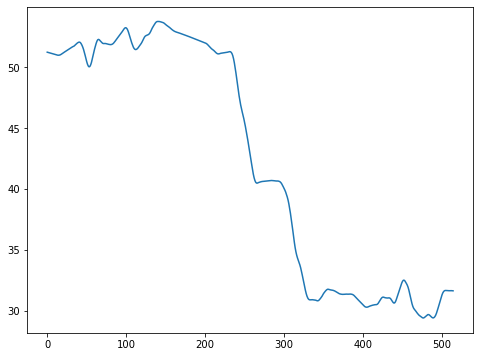

In [41]:
simple_df = new_df[new_df.Vehicle_ID == new_veh_list[0]].copy()
simple_df = simple_df[['Frame_ID','Local_X']]
simple_df.set_index('Frame_ID', inplace = True)
simple_df.sort_index(inplace=True)
simple_df.reset_index(drop=True, inplace=True)
plt.plot(simple_df)
simple_df.head()

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    #n_vars = 1 if type(data) is list else data.shape[1]
    variables = list(data.columns)
    df = data.copy()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['{}(t-{})'.format(j, i) for j in variables]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['{}(t)'.format(j) for j in variables]
        else:
            names += ['{}(t+{})'.format(j, i) for j in variables]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [43]:
series_to_supervised(simple_df, n_in=4, n_out=1, dropnan=False).head()

,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1),Local_X(t)
0,NaN,NaN,NaN,NaN,51.214252
1,NaN,NaN,NaN,51.214252,51.196441
2,NaN,NaN,51.214252,51.196441,51.178494
3,NaN,51.214252,51.196441,51.178494,51.160446
4,51.214252,51.196441,51.178494,51.160446,51.142331


In [44]:
transformed_df = series_to_supervised(simple_df, n_in=4, n_out=1, dropnan=True)
transformed_df.head()

,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1),Local_X(t)
4,51.214252,51.196441,51.178494,51.160446,51.142331
5,51.196441,51.178494,51.160446,51.142331,51.124182
6,51.178494,51.160446,51.142331,51.124182,51.106019
7,51.160446,51.142331,51.124182,51.106019,51.088021
8,51.142331,51.124182,51.106019,51.088021,51.069916


In [45]:
### Split the data set
from sklearn.model_selection import train_test_split

In [46]:
transformed_df.iloc[:,:-1]

,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1)
4,51.214252,51.196441,51.178494,51.160446
5,51.196441,51.178494,51.160446,51.142331
6,51.178494,51.160446,51.142331,51.124182
7,51.160446,51.142331,51.124182,51.106019
8,51.142331,51.124182,51.106019,51.088021
...,...,...,...,...
510,31.668082,31.660184,31.653473,31.653089
511,31.660184,31.653473,31.653089,31.655713
512,31.653473,31.653089,31.655713,31.657416
513,31.653089,31.655713,31.657416,31.656984


In [47]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df.iloc[:,:-1],transformed_df['Local_X(t)'], 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(357, 4) (154, 4) (357,) (154,)


In [48]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

In [49]:
print(X_train.describe())
X_train.shape

       Local_X(t-4)  Local_X(t-3)  Local_X(t-2)  Local_X(t-1)
count  3.570000e+02  3.570000e+02  3.570000e+02  3.570000e+02
mean   1.475322e-15  1.174286e-15  2.308766e-15 -6.692437e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.367345e+00 -1.361572e+00 -1.358854e+00 -1.354419e+00
25%   -1.166080e+00 -1.161489e+00 -1.156922e+00 -1.152961e+00
50%    2.488613e-01  2.166698e-01  1.828833e-01  1.472498e-01
75%    9.506863e-01  9.562820e-01  9.600661e-01  9.638601e-01
max    1.136656e+00  1.140431e+00  1.144156e+00  1.147849e+00


(357, 4)

### Apply prediction model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#### Vanilla LSTM

A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

In [51]:
n_steps = 4
n_features = 1

In [52]:
X_train = X_train.values
X_test = X_test.values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [53]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Train on 357 samples, validate on 154 samples
Epoch 1/100
357/357 [==============================] - 2s 5ms/sample - loss: 1895.0514 - mse: 1895.0511 - val_loss: 1812.3723 - val_mse: 1812.3722
Epoch 2/100
357/357 [==============================] - 0s 238us/sample - loss: 1882.8684 - mse: 1882.8684 - val_loss: 1798.2241 - val_mse: 1798.2240
Epoch 3/100
357/357 [==============================] - 0s 274us/sample - loss: 1865.3615 - mse: 1865.3613 - val_loss: 1775.7604 - val_mse: 1775.7604
Epoch 4/100
357/357 [==============================] - 0s 241us/sample - loss: 1835.1792 - mse: 1835.1791 - val_loss: 1731.0430 - val_mse: 1731.0430
Epoch 5/100
357/357 [==============================] - 0s 238us/sample - loss: 1765.6590 - mse: 1765.6589 - val_loss: 1614.1413 - val_mse: 1614.1412
Epoch 6/100
357/357 [==============================] - 0s 252us/sample - loss: 1566.8661 - mse: 1566.8661 - val_loss: 1248.2421 - val_mse: 1248.2421
Epoch 7/100
357/357 [==============================] - 0s 255u

In [54]:
hist = pd.DataFrame(Monitor.history)
hist['epoch'] = Monitor.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,0.212819,0.212819,0.235612,0.235612,95
96,0.209801,0.209801,0.232804,0.232804,96
97,0.212999,0.212999,0.242234,0.242234,97
98,0.209579,0.209579,0.226788,0.226788,98
99,0.207336,0.207336,0.235213,0.235213,99


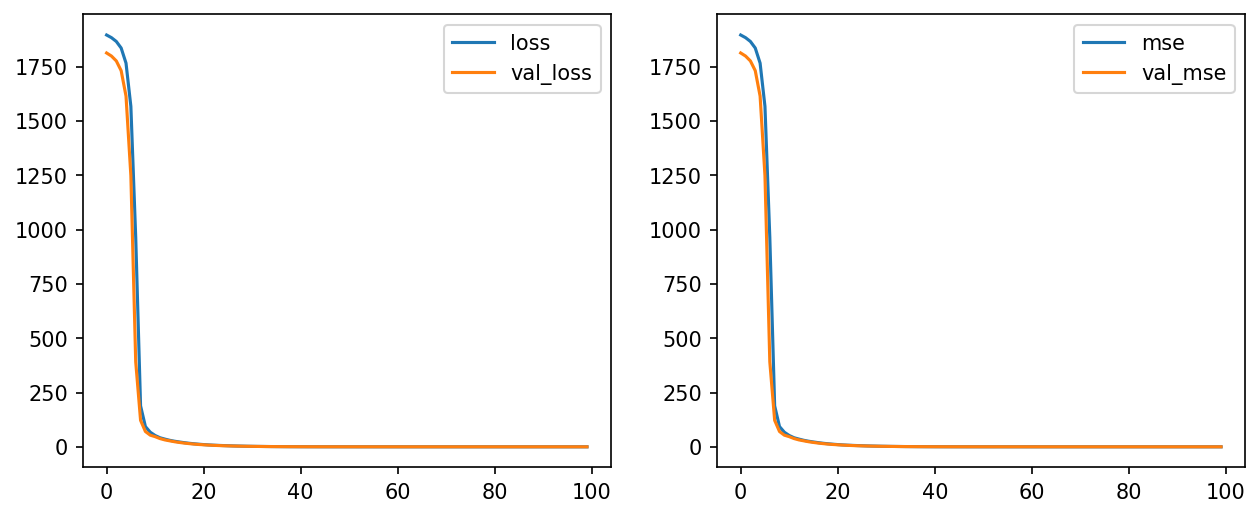

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['mse','val_mse']].plot(ax=axes[1])
plt.show()

In [56]:
yhat = model.predict(X_test, verbose=1)
#print(yhat)

154/154 [==============================] - 0s 3ms/sample


In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, yhat))
rms

0.4849871459835071

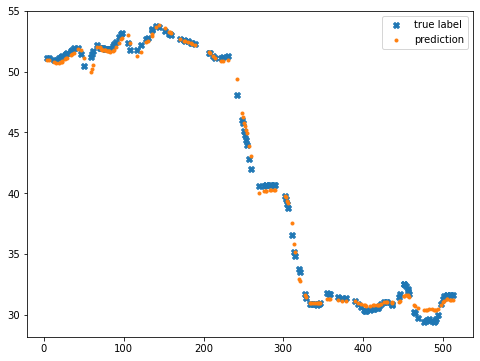

In [58]:
plt.scatter(y_test.index,y_test, label = "true label",marker = 'X', )
plt.scatter(y_test.index,yhat, label = "prediction",marker = '.')
plt.legend()
plt.show()

## 1 object and 1 target variable: Predict at time `t` and `t+1` (Multi-Step LSTM Models)

### Prepare the dataset

In [59]:
series_to_supervised(simple_df, n_in=4, n_out=2, dropnan=False).head()

,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1),Local_X(t),Local_X(t+1)
0,NaN,NaN,NaN,NaN,51.214252,51.196441
1,NaN,NaN,NaN,51.214252,51.196441,51.178494
2,NaN,NaN,51.214252,51.196441,51.178494,51.160446
3,NaN,51.214252,51.196441,51.178494,51.160446,51.142331
4,51.214252,51.196441,51.178494,51.160446,51.142331,51.124182


In [60]:
transformed_df = series_to_supervised(simple_df, n_in=4, n_out=2, dropnan=True)
transformed_df.head()

,Local_X(t-4),Local_X(t-3),Local_X(t-2),Local_X(t-1),Local_X(t),Local_X(t+1)
4,51.214252,51.196441,51.178494,51.160446,51.142331,51.124182
5,51.196441,51.178494,51.160446,51.142331,51.124182,51.106019
6,51.178494,51.160446,51.142331,51.124182,51.106019,51.088021
7,51.160446,51.142331,51.124182,51.106019,51.088021,51.069916
8,51.142331,51.124182,51.106019,51.088021,51.069916,51.052000


In [61]:
transformed_df[['Local_X(t)','Local_X(t+1)']].values

array([[51.142331  , 51.12418182],
       [51.12418182, 51.10601865],
       [51.10601865, 51.08802098],
       ...,
       [31.65741608, 31.65698368],
       [31.65698368, 31.6532028 ],
       [31.6532028 , 31.64486014]])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df.iloc[:,:-2],transformed_df[['Local_X(t)','Local_X(t+1)']], 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(357, 4) (153, 4) (357, 2) (153, 2)


In [63]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

In [64]:
print(X_train.describe())
X_train.shape

       Local_X(t-4)  Local_X(t-3)  Local_X(t-2)  Local_X(t-1)
count  3.570000e+02  3.570000e+02  3.570000e+02  3.570000e+02
mean   1.470346e-15  2.059977e-15  2.268960e-15 -6.468526e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.372996e+00 -1.366166e+00 -1.360197e+00 -1.355126e+00
25%   -1.169918e+00 -1.164507e+00 -1.158710e+00 -1.153098e+00
50%    1.782954e-01  1.432778e-01  1.072958e-01  7.183136e-02
75%    9.580206e-01  9.626895e-01  9.666225e-01  9.709811e-01
max    1.145475e+00  1.149578e+00  1.153589e+00  1.157543e+00


(357, 4)

### Apply prediction model

In [65]:
n_steps = 4
n_features = 1

In [66]:
X_train = X_train.values
X_test = X_test.values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [67]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Train on 357 samples, validate on 153 samples
Epoch 1/100
357/357 [==============================] - 2s 5ms/sample - loss: 1892.6820 - mse: 1892.6821 - val_loss: 1835.7256 - val_mse: 1835.7257
Epoch 2/100
357/357 [==============================] - 0s 238us/sample - loss: 1884.5107 - mse: 1884.5106 - val_loss: 1827.0042 - val_mse: 1827.0043
Epoch 3/100
357/357 [==============================] - 0s 288us/sample - loss: 1875.1749 - mse: 1875.1750 - val_loss: 1815.6651 - val_mse: 1815.6650
Epoch 4/100
357/357 [==============================] - 0s 219us/sample - loss: 1861.3159 - mse: 1861.3160 - val_loss: 1795.5646 - val_mse: 1795.5647
Epoch 5/100
357/357 [==============================] - 0s 258us/sample - loss: 1833.8622 - mse: 1833.8621 - val_loss: 1750.0271 - val_mse: 1750.0270
Epoch 6/100
357/357 [==============================] - 0s 269us/sample - loss: 1763.3380 - mse: 1763.3380 - val_loss: 1619.1072 - val_mse: 1619.1072
Epoch 7/100
357/357 [==============================] - 0s 274u

In [68]:
yhat = model.predict(X_test, verbose=1)
print(yhat[:5])

153/153 [==============================] - 0s 2ms/sample
[[30.451542 30.433975]
 [31.449556 31.375954]
 [30.330221 30.31709 ]
 [30.84705  30.795261]
 [31.012201 30.952255]]


In [69]:
yhat[:,0]

array([30.451542, 31.449556, 30.330221, 30.84705 , 31.012201, 50.07107 ,
       31.561111, 51.709846, 31.108248, 31.01705 , 30.725054, 50.94543 ,
       51.63701 , 45.205605, 52.48072 , 52.636215, 31.062275, 40.055927,
       30.842058, 51.776825, 31.103573, 50.84607 , 44.883106, 30.697992,
       30.956812, 31.429634, 52.5047  , 51.430065, 31.417961, 52.37558 ,
       31.016317, 52.861446, 31.06396 , 51.761257, 51.18972 , 30.830133,
       31.006628, 52.928963, 50.908325, 53.150864, 50.99476 , 30.67101 ,
       52.027397, 50.9787  , 30.95997 , 30.827019, 51.723495, 40.118008,
       51.24432 , 30.368048, 52.292885, 51.696655, 39.85156 , 31.378326,
       30.828548, 30.926392, 51.537987, 51.67636 , 30.756475, 52.63371 ,
       51.882347, 51.016136, 51.84381 , 50.802673, 51.05282 , 51.07395 ,
       31.38052 , 51.68508 , 45.770897, 51.76172 , 30.324259, 30.860281,
       50.88908 , 40.104992, 52.402206, 31.037542, 45.50051 , 51.861073,
       30.676344, 51.107216, 39.11026 , 51.936466, 

In [70]:
y_test.iloc[:,1]

484    29.606848
453    32.351807
479    29.598867
438    30.641876
372    31.360688
         ...    
406    30.349110
400    30.411604
98     53.220900
500    31.473545
358    31.718217
Name: Local_X(t+1), Length: 153, dtype: float64

In [71]:
rms1 = sqrt(mean_squared_error(y_test.iloc[:,0], yhat[:,0]))
rms1

0.47934308613682397

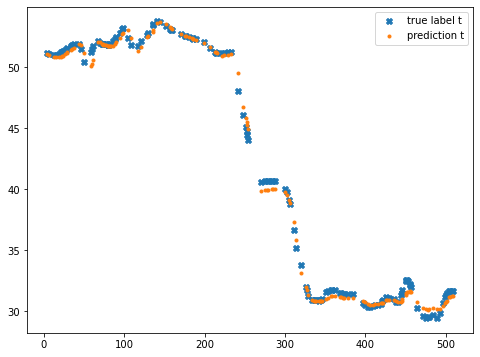

In [57]:
plt.scatter(y_test.index,y_test.iloc[:,0], label = "true label t",marker = 'X', )
plt.scatter(y_test.index,yhat[:,0], label = "prediction t",marker = '.')
plt.legend()
plt.show()

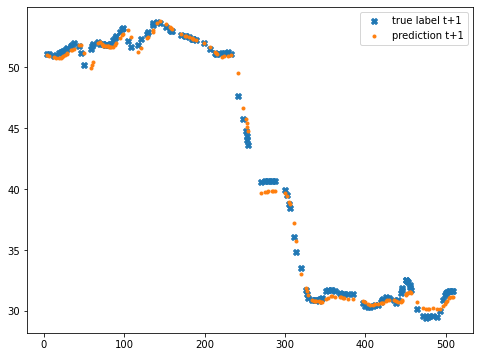

In [56]:
plt.scatter(y_test.index,y_test.iloc[:,1], label = "true label t+1",marker = 'X', )
plt.scatter(y_test.index,yhat[:,1], label = "prediction t+1",marker = '.')
plt.legend()
plt.show()

## 1 object, 2 target variables, Predict at time `t` (Multiple Parallel Series)

2 target variables are Local_X and v_Vel

### Prepare the data set

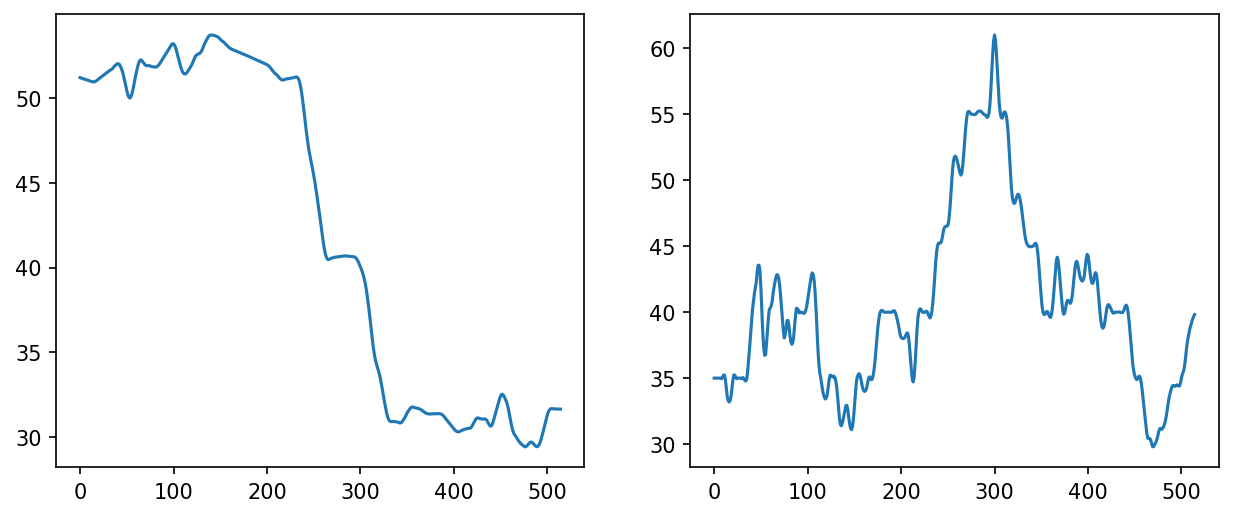

,Local_X,v_Vel
0,51.214252,35.000000
1,51.196441,34.998425
2,51.178494,35.000227
3,51.160446,35.001526
4,51.142331,35.002322


In [75]:
simple_df = new_df[new_df.Vehicle_ID == new_veh_list[0]].copy()
simple_df = simple_df[['Frame_ID','Local_X','v_Vel']]
simple_df.set_index('Frame_ID', inplace = True)
simple_df.sort_index(inplace=True)
simple_df.reset_index(drop=True, inplace=True)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
simple_df['Local_X'].plot(ax=axes[0])
simple_df['v_Vel'].plot(ax=axes[1])
plt.show()
simple_df.head()

In [76]:
series_to_supervised(simple_df, n_in=4, n_out=2, dropnan=False).head()

,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),Local_X(t),v_Vel(t),Local_X(t+1),v_Vel(t+1)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.214252,35.000000,51.196441,34.998425
1,NaN,NaN,NaN,NaN,NaN,NaN,51.214252,35.000000,51.196441,34.998425,51.178494,35.000227
2,NaN,NaN,NaN,NaN,51.214252,35.000000,51.196441,34.998425,51.178494,35.000227,51.160446,35.001526
3,NaN,NaN,51.214252,35.000000,51.196441,34.998425,51.178494,35.000227,51.160446,35.001526,51.142331,35.002322
4,51.214252,35.0,51.196441,34.998425,51.178494,35.000227,51.160446,35.001526,51.142331,35.002322,51.124182,35.002615


In [79]:
transformed_df = series_to_supervised(simple_df, n_in=4, n_out=1, dropnan=True)
transformed_df.head()

,Local_X(t-4),v_Vel(t-4),Local_X(t-3),v_Vel(t-3),Local_X(t-2),v_Vel(t-2),Local_X(t-1),v_Vel(t-1),Local_X(t),v_Vel(t)
4,51.214252,35.000000,51.196441,34.998425,51.178494,35.000227,51.160446,35.001526,51.142331,35.002322
5,51.196441,34.998425,51.178494,35.000227,51.160446,35.001526,51.142331,35.002322,51.124182,35.002615
6,51.178494,35.000227,51.160446,35.001526,51.142331,35.002322,51.124182,35.002615,51.106019,35.000914
7,51.160446,35.001526,51.142331,35.002322,51.124182,35.002615,51.106019,35.000914,51.088021,35.001255
8,51.142331,35.002322,51.124182,35.002615,51.106019,35.000914,51.088021,35.001255,51.069916,34.958581


In [80]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df.iloc[:,:-2],transformed_df[['Local_X(t)','v_Vel(t)']], 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(357, 8) (154, 8) (357, 2) (154, 2)


In [81]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std
X_train.describe()

### Apply prediction model

In [84]:
n_steps = 4
n_features = 1
X_train = X_train.values
X_test = X_test.values
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [86]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps*2, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Train on 357 samples, validate on 154 samples
Epoch 1/100
357/357 [==============================] - 2s 5ms/sample - loss: 1799.9222 - mse: 1799.9222 - val_loss: 1749.3664 - val_mse: 1749.3663
Epoch 2/100
357/357 [==============================] - 0s 314us/sample - loss: 1788.8126 - mse: 1788.8129 - val_loss: 1735.8922 - val_mse: 1735.8922
Epoch 3/100
357/357 [==============================] - 0s 291us/sample - loss: 1769.7496 - mse: 1769.7496 - val_loss: 1701.9643 - val_mse: 1701.9642
Epoch 4/100
357/357 [==============================] - 0s 314us/sample - loss: 1692.7764 - mse: 1692.7762 - val_loss: 1466.9931 - val_mse: 1466.9930
Epoch 5/100
357/357 [==============================] - 0s 336us/sample - loss: 1041.0888 - mse: 1041.0887 - val_loss: 544.9053 - val_mse: 544.9053
Epoch 6/100
357/357 [==============================] - 0s 314us/sample - loss: 219.0419 - mse: 219.0419 - val_loss: 258.6629 - val_mse: 258.6629
Epoch 7/100
357/357 [==============================] - 0s 322us/samp

In [87]:
yhat = model.predict(X_test, verbose=1)
print(yhat[:5])

154/154 [==============================] - 0s 3ms/sample
[[52.40429  35.17813 ]
 [50.92724  38.53888 ]
 [31.337734 40.129745]
 [41.184547 51.725895]
 [52.149414 42.270027]]


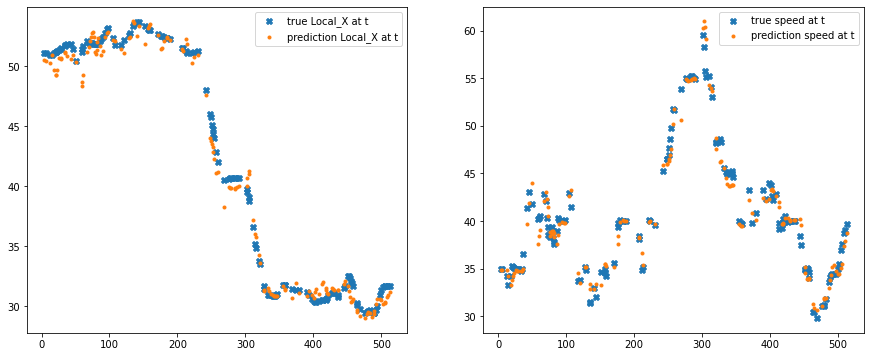

In [95]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(y_test.index,y_test.iloc[:,0], label = "true Local_X at t",marker = 'X', )
plt.scatter(y_test.index,yhat[:,0], label = "prediction Local_X at t",marker = '.')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(y_test.index,y_test.iloc[:,1], label = "true speed at t",marker = 'X', )
plt.scatter(y_test.index,yhat[:,1], label = "prediction speed at t",marker = '.')
plt.legend()
plt.show()

## 1 object, 2 target variables, predict at time `t`, multiple input series

### Data preparation


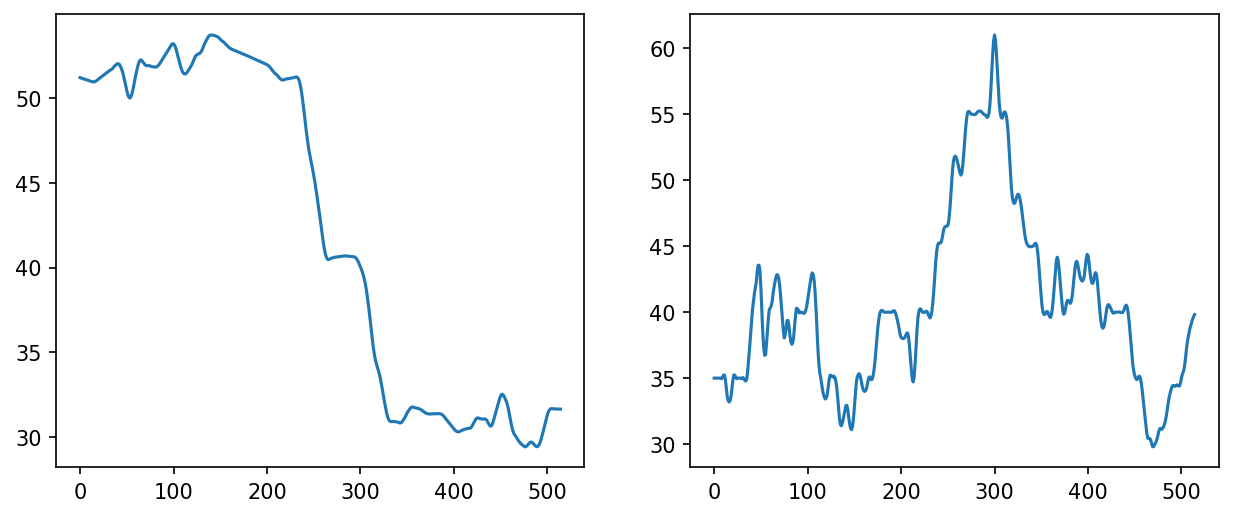

,Local_X,Local_Y,v_Vel
0,51.214252,39.647098,35.000000
1,51.196441,43.146895,34.998425
2,51.178494,46.646872,35.000227
3,51.160446,50.146978,35.001526
4,51.142331,53.647163,35.002322


In [103]:
simple_df = new_df[new_df.Vehicle_ID == new_veh_list[0]].copy()
simple_df = simple_df[['Frame_ID','Local_X','Local_Y','v_Vel']]
simple_df.set_index('Frame_ID', inplace = True)
simple_df.sort_index(inplace=True)
simple_df.reset_index(drop=True, inplace=True)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
simple_df['Local_X'].plot(ax=axes[0])
simple_df['v_Vel'].plot(ax=axes[1])
plt.show()
simple_df.head()

In [102]:
transformed_df = series_to_supervised(simple_df, n_in=4, n_out=1, dropnan=True)
transformed_df.head()

,Local_X(t-4),Local_Y(t-4),v_Vel(t-4),Local_X(t-3),Local_Y(t-3),v_Vel(t-3),Local_X(t-2),Local_Y(t-2),v_Vel(t-2),Local_X(t-1),Local_Y(t-1),v_Vel(t-1),Local_X(t),Local_Y(t),v_Vel(t)
4,51.214252,39.647098,35.000000,51.196441,43.146895,34.998425,51.178494,46.646872,35.000227,51.160446,50.146978,35.001526,51.142331,53.647163,35.002322
5,51.196441,43.146895,34.998425,51.178494,46.646872,35.000227,51.160446,50.146978,35.001526,51.142331,53.647163,35.002322,51.124182,57.147378,35.002615
6,51.178494,46.646872,35.000227,51.160446,50.146978,35.001526,51.142331,53.647163,35.002322,51.124182,57.147378,35.002615,51.106019,60.647422,35.000914
7,51.160446,50.146978,35.001526,51.142331,53.647163,35.002322,51.124182,57.147378,35.002615,51.106019,60.647422,35.000914,51.088021,64.147501,35.001255
8,51.142331,53.647163,35.002322,51.124182,57.147378,35.002615,51.106019,60.647422,35.000914,51.088021,64.147501,35.001255,51.069916,67.643312,34.958581


In [108]:
transformed_df.drop(columns=['Local_Y(t)'],inplace=True)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(transformed_df.iloc[:,:-2],transformed_df[['Local_X(t)','v_Vel(t)']], 
                                                    test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(357, 12) (154, 12) (357, 2) (154, 2)


In [110]:
### Standardize the data
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std
X_train.describe()

,Local_X(t-4),Local_Y(t-4),v_Vel(t-4),Local_X(t-3),Local_Y(t-3),v_Vel(t-3),Local_X(t-2),Local_Y(t-2),v_Vel(t-2),Local_X(t-1),Local_Y(t-1),v_Vel(t-1)
count,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02,3.570000e+02
mean,1.475322e-15,3.284021e-16,-2.639656e-15,1.174286e-15,-1.243947e-17,-3.288997e-15,2.308766e-15,-4.304058e-16,1.114577e-15,-6.692437e-16,-1.299925e-15,-4.831492e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.367345e+00,-1.667882e+00,-1.626871e+00,-1.361572e+00,-1.668580e+00,-1.624022e+00,-1.358854e+00,-1.669284e+00,-1.622166e+00,-1.354419e+00,-1.669999e+00,-1.621433e+00
25%,-1.166080e+00,-8.356201e-01,-8.437423e-01,-1.161489e+00,-8.370283e-01,-8.317377e-01,-1.156922e+00,-8.384101e-01,-8.300691e-01,-1.152961e+00,-8.397491e-01,-8.249706e-01
50%,2.488613e-01,-1.055727e-01,-9.665806e-02,2.166698e-01,-1.044232e-01,-9.495026e-02,1.828833e-01,-1.031124e-01,-9.759135e-02,1.472498e-01,-1.016232e-01,-1.002815e-01
75%,9.506863e-01,8.979312e-01,3.542775e-01,9.562820e-01,8.976975e-01,3.542584e-01,9.600661e-01,8.975264e-01,3.515827e-01,9.638601e-01,8.974179e-01,3.463113e-01
max,1.136656e+00,1.739317e+00,3.055842e+00,1.140431e+00,1.738859e+00,2.991404e+00,1.144156e+00,1.738440e+00,2.980060e+00,1.147849e+00,1.738053e+00,3.029597e+00


In [111]:
X_train = X_train.values
X_test = X_test.values

In [112]:
n_steps = 4
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [113]:
X_train.shape

(357, 12, 1)

In [115]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps*3, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# For saving the best model during the whole training process.
#checkpointer = callbacks.ModelCheckpoint(filepath='BestModel.h5', monitor='val_loss', save_best_only=True)

#### Interrupt training if `val_loss` stops improving for over 10 epochs #######
stop_learn= tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')


# fit model
Monitor = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[stop_learn],
                    validation_data=(X_test, y_test), verbose=1)

Train on 357 samples, validate on 154 samples
Epoch 1/100
357/357 [==============================] - 2s 7ms/sample - loss: 1797.1003 - mse: 1797.1003 - val_loss: 1744.3626 - val_mse: 1744.3627
Epoch 2/100
357/357 [==============================] - 0s 442us/sample - loss: 1780.2005 - mse: 1780.2007 - val_loss: 1716.9481 - val_mse: 1716.9480
Epoch 3/100
357/357 [==============================] - 0s 549us/sample - loss: 1717.4922 - mse: 1717.4923 - val_loss: 1473.6404 - val_mse: 1473.6404
Epoch 4/100
357/357 [==============================] - 0s 445us/sample - loss: 910.8924 - mse: 910.8923 - val_loss: 512.4942 - val_mse: 512.4943
Epoch 5/100
357/357 [==============================] - 0s 448us/sample - loss: 600.4077 - mse: 600.4078 - val_loss: 667.0654 - val_mse: 667.0654
Epoch 6/100
357/357 [==============================] - 0s 434us/sample - loss: 371.5620 - mse: 371.5621 - val_loss: 321.1720 - val_mse: 321.1720
Epoch 7/100
357/357 [==============================] - 0s 428us/sample - l

In [116]:
yhat = model.predict(X_test, verbose=1)
print(yhat[:5])

154/154 [==============================] - 0s 2ms/sample
[[52.861416 35.15887 ]
 [52.02561  39.586807]
 [31.811306 40.620678]
 [42.695164 53.04565 ]
 [52.164997 41.95745 ]]


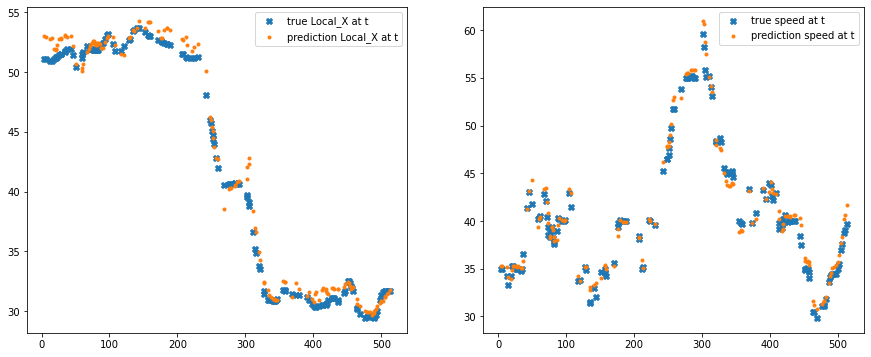

In [117]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(y_test.index,y_test.iloc[:,0], label = "true Local_X at t",marker = 'X', )
plt.scatter(y_test.index,yhat[:,0], label = "prediction Local_X at t",marker = '.')
plt.legend()
plt.subplot(1,2,2)
plt.scatter(y_test.index,y_test.iloc[:,1], label = "true speed at t",marker = 'X', )
plt.scatter(y_test.index,yhat[:,1], label = "prediction speed at t",marker = '.')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'tensorflow_datasets'